First we check out our data by loading it, checking the data type, the first keys

In [1]:
import pickle
with open("exp rat 2.pkl", "rb") as f:
	data = pickle.load(f) 


print(type(data))  # --> it is a dictionary
print(data.keys())  # check the keys of this dictionary
#print(data) # check out what the data looks like




<class 'dict'>
dict_keys(['sacc drinking session start time', 'format', 'event_times', 'CTA injection time', 'neurons'])


To understand the Structure of our data set in more detail, we check out the content of each key

In [16]:
# Check the event times (stimuli times)
print("Event Times:", data["event_times"].keys())
print("Event Times:", data["event_times"])

# Check the drinking session start time and CTA injection time
print("Saccharin drinking start time:", data["sacc drinking session start time"])
print("CTA injection time:", data["CTA injection time"])

# Check how many neurons were recorded
print("Number of neurons recorded:", len(data["neurons"]))

# Display an example neuron
print("Example neuron data:", data["neurons"][0])  # Checking the first neuron


Event Times: dict_keys(['water', 'sugar'])
Event Times: {'water': array([   183.44936667,    203.53743333,    223.62546667,    243.7135    ,
          263.80153333,    283.88956667,    303.9776    ,    324.0656    ,
          344.15363333,    364.24163333,   7379.13906667,   7399.22706667,
         7419.31506667,   7439.40303333,   7459.49103333,   7479.57903333,
         7499.66703333,   7519.75503333,   7539.84303333,   7559.93103333,
        14574.83256667,  14594.9206    ,  14615.0086    ,  14635.09663333,
        14655.18466667,  14675.27266667,  14695.3607    ,  14715.4487    ,
        14735.53673333,  14755.62473333,  21770.5347    ,  21790.62276667,
        21810.7108    ,  21830.79886667,  21850.8869    ,  21870.97496667,
        21891.063     ,  21911.15106667,  21931.23913333,  21951.32716667,
        26106.27283333,  26126.3609    ,  26146.44896667,  26166.53703333,
        26186.62506667,  26206.71313333,  26226.8012    ,  26246.88926667,
        26266.97733333,  26287.065

Therewith we get:
- the times when saccharin and water were given.
- the start of the saccharin drinking session and the time of LiCl/saline injection.
- count the number of neurons recorded.
- print one neuron’s data to understand its format.

Now that we have understood the neuron's data format we can rearrange it for better reading for us:

In [3]:
import numpy as np
import pandas as pd

# Extract neuron spike data
neurons_data = data['neurons']

# Create a DataFrame for neurons
neurons_list = []
for neuron in neurons_data:
    electrode, cluster, spike_times = neuron[:3]  # Extract first 3 elements
    neurons_list.append({
        "Electrode": electrode,
        "Cluster": cluster,
        "Spike_Count": len(spike_times),  # Number of spikes
        "First_Spike": spike_times[0],  # First spike time
        "Last_Spike": spike_times[-1]  # Last spike time
    })

# Convert to a Pandas DataFrame
df_neurons = pd.DataFrame(neurons_list)
print(df_neurons.head())


   Electrode  Cluster  Spike_Count  First_Spike     Last_Spike
0          4       29      3988477     0.064767  168968.837400
1          5       17      2780558     0.013400  168968.880167
2          9       12      2570990     0.000133  168968.894900
3         12       10      1228385     0.045300  168968.355400
4         13       12       730675     0.034933  168966.419700


Now that we have understood our data, we start with the first analysis task:
The exclusion 

The steps we'll take are:
1) Define Exclusion criteria to remove multi-unit activity and keep single neuron acitivtiy
- refractory period using auto-correlation
2) compute auto-correlogram to inspect
3) decide ...

Write a function that plots our auto-correlograms

In [4]:
def correlogram(t1, t2=None, binsize=.001, limit=.02, auto=False,
                density=False):
    """Return crosscorrelogram of two spike trains.
    Essentially, this algorithm subtracts each spike time in ⁠ t1 ⁠
    from all of ⁠ t2 ⁠ and bins the results with np.histogram, though
    several tweaks were made for efficiency.
    Originally authored by Chris Rodger, copied from OpenElectrophy, licenced
    with CeCill-B. Examples and testing written by exana team.

    Parameters
    ---------
    t1 : np.array
        First spiketrain, raw spike times in seconds.
    t2 : np.array
        Second spiketrain, raw spike times in seconds.
    binsize : float
        Width of each bar in histogram in seconds.
    limit : float
        Positive and negative extent of histogram, in seconds.
    auto : bool
        If True, then returns autocorrelogram of ⁠ t1 ⁠ and in
        this case ⁠ t2 ⁠ can be None. Default is False.
    density : bool
        If True, then returns the probability density function.
    See also
    --------
    :func:⁠ numpy.histogram ⁠ : The histogram function in use.

    Returns
    -------
    (count, bins) : tuple
        A tuple containing the bin right edges and the
        count/density of spikes in each bin.
    Note
    ----
    ⁠ bins ⁠ are relative to ⁠ t1 ⁠. That is, if ⁠ t1 ⁠ leads ⁠ t2 ⁠, then
    ⁠ count ⁠ will peak in a positive time bin.

    Examples
    --------
    >>> t1 = np.arange(0, .5, .1)
    >>> t2 = np.arange(0.1, .6, .1)
    >>> limit = 1
    >>> binsize = .1
    >>> counts, bins = correlogram(t1=t1, t2=t2, binsize=binsize,
    ...                            limit=limit, auto=False)
    >>> counts
    array([0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 4, 3, 2, 1, 0, 0, 0, 0])

    The interpretation of this result is that there are 5 occurences where
    in the bin 0 to 0.1, i.e.

    # TODO fix
    # >>> idx = np.argmax(counts)
    # >>> '%.1f, %.1f' % (abs(bins[idx - 1]), bins[idx])
    # '0.0, 0.1'

    The correlogram algorithm is identical to, but computationally faster than
    the histogram of differences of each timepoint, i.e.

    # TODO Fix the doctest
    # >>> diff = [t2 - t for t in t1]
    # >>> counts2, bins = np.histogram(diff, bins=bins)
    # >>> np.array_equal(counts2, counts)
    # True
    """
    if auto: t2 = t1
    # For auto-CCGs, make sure we use the same exact values
    # Otherwise numerical issues may arise when we compensate for zeros later
    if not int(limit * 1e10) % int(binsize * 1e10) == 0:
        raise ValueError(
            'Time limit {} must be a '.format(limit) +
            'multiple of binsize {}'.format(binsize) +
            ' remainder = {}'.format(limit % binsize))
    # For efficiency, ⁠ t1 ⁠ should be no longer than ⁠ t2 ⁠
    swap_args = False
    if len(t1) > len(t2):
        swap_args = True
        t1, t2 = t2, t1

    # Sort both arguments (this takes negligible time)
    t1 = np.sort(t1)
    t2 = np.sort(t2)

    # Determine the bin edges for the histogram
    # Later we will rely on the symmetry of ⁠ bins ⁠ for undoing ⁠ swap_args ⁠
    limit = float(limit)

    # The numpy.arange method overshoots slightly the edges i.e. binsize + epsilon
    # which leads to inclusion of spikes falling on edges.
    bins = np.arange(-limit, limit + binsize, binsize)

    # Determine the indexes into ⁠ t2 ⁠ that are relevant for each spike in ⁠ t1 ⁠
    ii2 = np.searchsorted(t2, t1 - limit)
    jj2 = np.searchsorted(t2, t1 + limit)

    # Concatenate the recentered spike times into a big array
    # We have excluded spikes outside of the histogram range to limit
    # memory use here.
    big = np.concatenate([t2[i:j] - t for t, i, j in zip(t1, ii2, jj2)])

    # Actually do the histogram. Note that calls to np.histogram are
    # expensive because it does not assume sorted data.
    count, bins = np.histogram(big, bins=bins, density=density)

    if auto:
        # Compensate for the peak at time zero that results in autocorrelations
        # by subtracting the total number of spikes from that bin. Note
        # possible numerical issue here because 0.0 may fall at a bin edge.
        c_temp, bins_temp = np.histogram([0.], bins=bins)
        bin_containing_zero = np.nonzero(c_temp)[0][0]
        count[bin_containing_zero] = 0#-= len(t1)

    # Finally compensate for the swapping of t1 and t2
    if swap_args:
        # Here we rely on being able to simply reverse ⁠ counts ⁠. This is only
        # possible because of the way ⁠ bins ⁠ was defined (bins = -bins[::-1])
        count = count[::-1]

    return count, bins[1:]




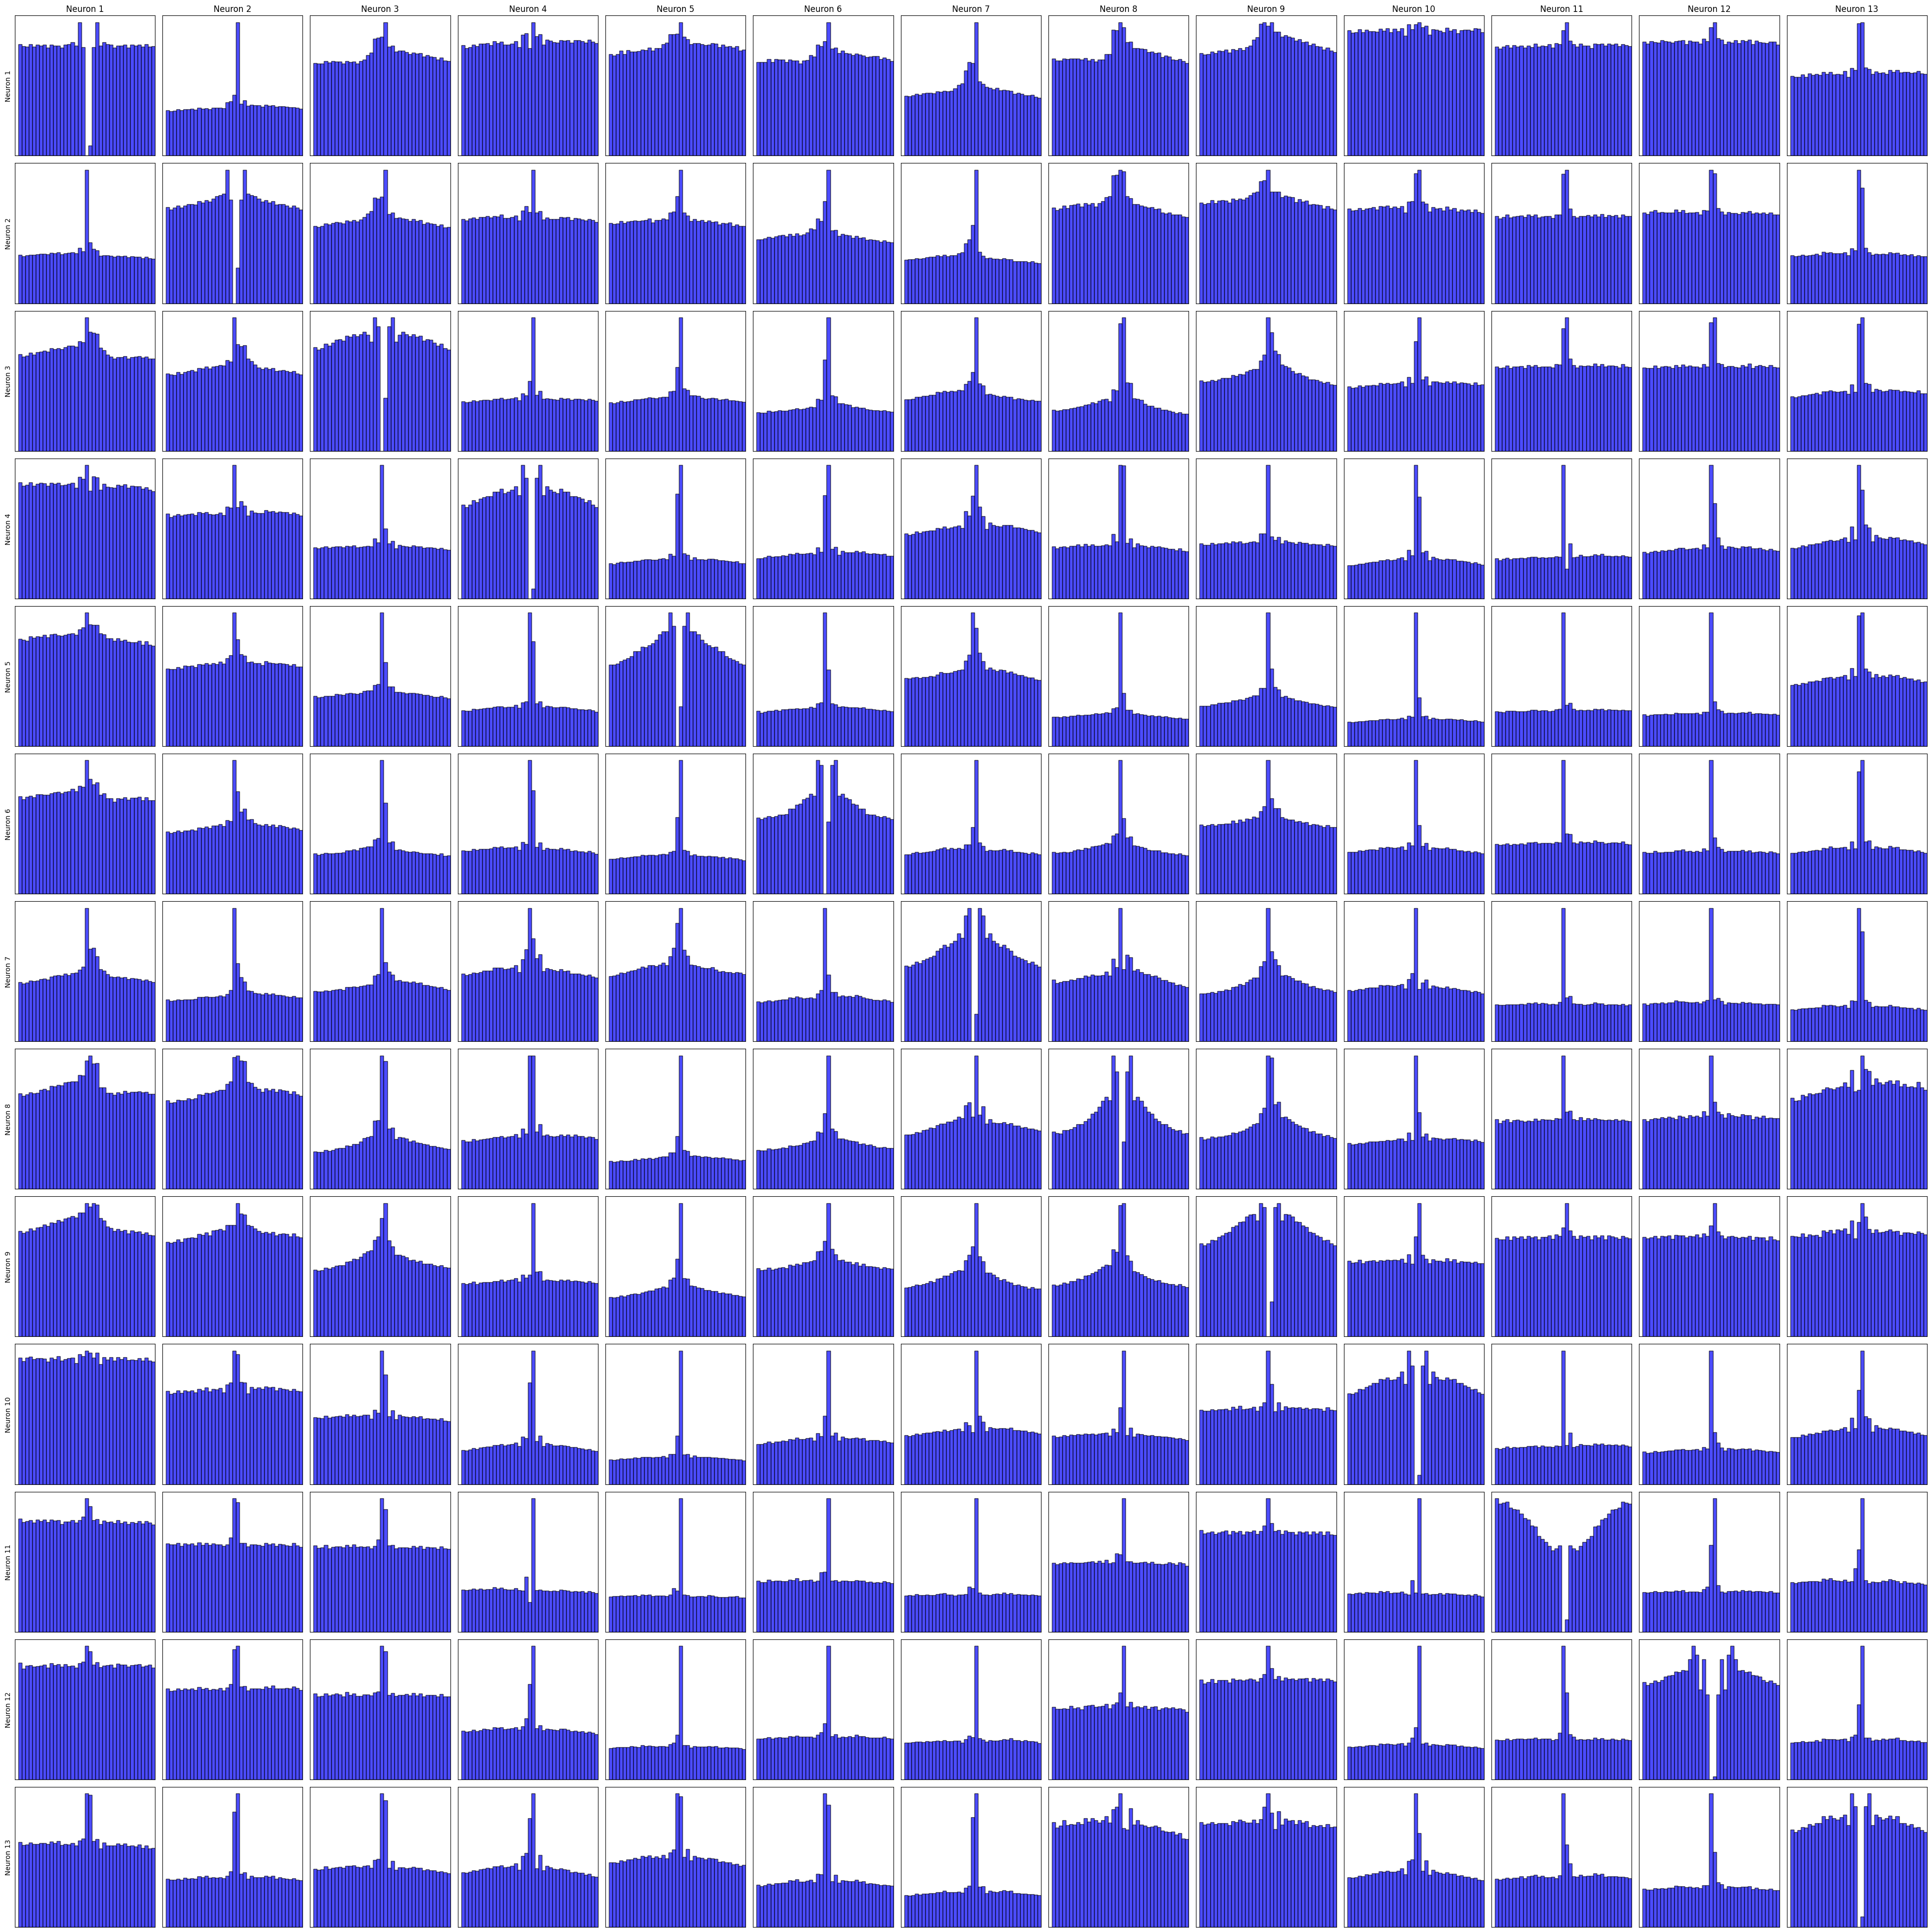

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def plot_correlogram_matrix(neurons_data, binsize=0.001, limit=0.02):
    num_neurons = len(neurons_data)
    fig, axes = plt.subplots(num_neurons, num_neurons, figsize=(num_neurons * 3, num_neurons * 3))
    
    for i, neuron_i in enumerate(neurons_data):
        t1 = neuron_i[:3][2]  # Extract spike times

        for j, neuron_j in enumerate(neurons_data):
            t2 = neuron_j[:3][2]  # Extract spike times

            # Compute correlogram
            counts, bins = correlogram(t1, t2=t2, binsize=binsize, limit=limit, auto=(i == j), density=False)

            # Ensure counts and bins align correctly
            if len(counts) > len(bins) - 1:
                counts = counts[:-1]

            bin_centers = (bins[:-1] + bins[1:]) / 2

            # Plot in the matrix
            ax = axes[i, j] if num_neurons > 1 else axes
            ax.bar(bin_centers, counts, width=np.diff(bins), align='center', color='b', alpha=0.7, edgecolor='k')
            ax.set_xlim(-limit, limit)
            ax.set_xticks([])
            ax.set_yticks([])

            # Labels for the first row and first column
            if i == 0:
                ax.set_title(f"Neuron {j+1}")
            if j == 0:
                ax.set_ylabel(f"Neuron {i+1}")

    plt.tight_layout()
    plt.show()

# Example usage:
plot_correlogram_matrix(neurons_data)


#### Interpretation of the Correlogram ####
Based on the correlaogram we can see that each auto-correlogram depicts a refractory period, confirming that each spike-train only contains the peaks of one neuron. 
Furthermore, we can see that neuron most neurons seem to be regular spiking neurons (refractory period, peak shortly before and sfter the gap)
(maybe except neuron 11)
Neuron 6,7,8 might be bursting neurons.

Due to the single peak in each cross-correlogram, we could infer that these neurons seem to be excitatory connected.

### Next step: preparing our data for the analysis ###

We segment our data in Pre-CTA, CTA and Post-CTA to enable comparisons
1) Find the relevant time points
- extract the data point "sacc drinking session start time"
- extract the data point "CTA injection time"
- get the maximum number of spike-times to find the end of our experiment period
2) Define the time windows


In [ ]:
import numpy as np

# Assuming 'data' is a dictionary with your time points:
sacc_start = data["sacc drinking session start time"]
cta_time = data["CTA injection time"]  # This is the saline injection for control rats

# Function to extract spike times for each neuron
def get_spike_times(neurons_data):
    """
    Extract spike times from each neuron.
    Assumes that each element in neurons_data is a list/tuple where index 2 holds the spike times.
    Returns a list of spike time arrays.
    """
    spike_times_list = []
    for neuron in neurons_data:
        times = neuron[2]  # extract spike times
        spike_times_list.append(np.array(times))  # ensure it's a NumPy array if needed
    return spike_times_list

# Extract spike times for all neurons
spike_times_list = get_spike_times(neurons_data)

# Find the maximum spike time across all neurons (ignoring neurons with no spikes)
max_time = max([np.max(times) for times in spike_times_list if len(times) > 0])

# Define time windows
non_stimuli_time = (0, sacc_start)                      # Before saccharin drinking session
pre_CTA_time = (sacc_start, cta_time)                # Before injection window
post_CTA_time = (cta_time + 3 * 3600, max_time)        # Post-injection: from 3 hours after injection to experiment end

print("Spike times for each neuron:", spike_times_list)
print("Non-stimuli window:", non_stimuli_time)
print("Pre-CTA window:", pre_CTA_time)
print("Post-CTA window:", post_CTA_time)




Non-stimuli window: (0, 86040)
Spike times for each neuron: [array([6.47666667e-02, 6.65666667e-02, 1.06100000e-01, ...,
       1.68968764e+05, 1.68968797e+05, 1.68968837e+05], shape=(3988477,)), array([1.34000000e-02, 1.34700000e-01, 1.83533333e-01, ...,
       1.68968842e+05, 1.68968866e+05, 1.68968880e+05], shape=(2780558,)), array([1.33333333e-04, 7.06666667e-03, 2.56666667e-02, ...,
       1.68968842e+05, 1.68968866e+05, 1.68968895e+05], shape=(2570990,)), array([4.53000000e-02, 6.07000000e-02, 1.32866667e-01, ...,
       1.68968105e+05, 1.68968341e+05, 1.68968355e+05], shape=(1228385,)), array([3.49333333e-02, 1.36500000e-01, 1.43833333e-01, ...,
       1.68965213e+05, 1.68965228e+05, 1.68966420e+05], shape=(730675,)), array([1.34766667e-01, 1.36500000e-01, 1.43800000e-01, ...,
       1.68968362e+05, 1.68968798e+05, 1.68968892e+05], shape=(935732,)), array([6.47666667e-02, 1.43800000e-01, 3.51733333e-01, ...,
       1.68966608e+05, 1.68967437e+05, 1.68967850e+05], shape=(761081,)

### Next step: firing rates



In [55]:
import numpy as np

# Function to compute firing rates within a time window (one value per neuron)
def compute_firing_rates(neurons, time_window):
    start, end = time_window
    rates = []  # collect firing rate for each neuron
    for neuron in neurons:
        # Assuming neuron is a tuple/list where the third element contains the spike times
        _, _, spikes = neuron
        # Count the spikes that occur within the time window
        spikes_in_window = [spike for spike in spikes if start <= spike <= end]
        # Compute firing rate (spikes per second)
        rate = len(spikes_in_window) / (end - start)
        rates.append(rate)
    return np.array(rates)

# Function to compute the standard deviation of firing rates for each neuron
# by binning the time window into smaller bins.
def compute_firing_rate_std(neurons, time_window, bin_width=0.05):
    """
    For each neuron, bin the spike times in the given time window into bins of width `bin_width`
    and compute the standard deviation of the resulting binned firing rates.
    
    Parameters:
        neurons (list): List of neurons; each neuron must have spike times at index 2.
        time_window (tuple): (start, end) time in seconds.
        bin_width (float): Width of each bin in seconds.
    
    Returns:
        list: Standard deviation of the firing rates for each neuron.
    """
    start, end = time_window
    std_list = []
    # Define bin edges for the entire window
    bins = np.arange(start, end + bin_width, bin_width)
    
    for neuron in neurons:
        _, _, spikes = neuron
        # Select spikes that fall within the time window
        spikes_in_window = np.array([spike for spike in spikes if start <= spike <= end])
        # Compute spike counts in each bin
        counts, _ = np.histogram(spikes_in_window, bins=bins)
        # Convert counts to rates (spikes per second)
        rates = counts / bin_width
        # Compute standard deviation of the binned rates
        std_rate = np.std(rates)
        std_list.append(std_rate)
    
    return std_list

# Example usage for pre-CTA and post-CTA time windows:
non_stim_rate = compute_firing_rates(neurons_data, non_stimuli_time)
pre_CTA_rates = compute_firing_rates(neurons_data, pre_CTA_time)
post_CTA_rates = compute_firing_rates(neurons_data, post_CTA_time)

non_stim_std = compute_firing_rate_std(neurons_data, non_stimuli_time, bin_width=0.05)
pre_CTA_std = compute_firing_rate_std(neurons_data, pre_CTA_time, bin_width=0.05)
post_CTA_std = compute_firing_rate_std(neurons_data, post_CTA_time, bin_width=0.05)

# Display the firing rates for each neuron
print("Non-stimuli firing rates for each neuron:", non_stim_rate)
print("Pre-CTA firing rates for each neuron:", pre_CTA_rates)
print("Post-CTA firing rates for each neuron:", post_CTA_rates)

# Display per-neuron variability (standard deviation computed from binned rates)
print("Per-neuron standard deviation (non-stimuli):", non_stim_std)
print("Per-neuron standard deviation (pre-CTA):", pre_CTA_std)
print("Per-neuron standard deviation (post-CTA):", post_CTA_std)

# Display overall summary statistics
print("Mean non-stimuli firing rate:", np.mean(non_stim_rate))
print("Standard deviation of non-stimuli firing rates (across neurons):", np.std(non_stim_rate))
print("Mean pre-CTA firing rate:", np.mean(pre_CTA_rates))
print("Standard deviation of pre-CTA firing rates (across neurons):", np.std(pre_CTA_rates))
print("Mean post-CTA firing rate:", np.mean(post_CTA_rates))
print("Standard deviation of post-CTA firing rates (across neurons):", np.std(post_CTA_rates))







Non-stimuli firing rates for each neuron: [30.8788238  16.37785914 13.3955602   7.03240353  5.08318224  6.75590423
  4.8788238   6.40332404 18.00390516  7.27318689  7.90049977  6.28321711
  3.86947931]
Pre-CTA firing rates for each neuron: [23.166875   21.24395833 14.63375     7.12416667  3.98208333  4.99625
  3.94416667  6.06833333 18.58041667  6.72625     9.654375    6.99833333
  2.129375  ]
Post-CTA firing rates for each neuron: [15.67794929 16.69351623 18.25568356  8.22171522  3.68730246  4.38354143
  4.33616207  4.92630988 15.73456688  6.64117539  7.51499042  8.04335198
  2.98426107]
Per-neuron standard deviation (non-stimuli): [np.float64(26.46046246981198), np.float64(20.044877422869657), np.float64(19.581468501969127), np.float64(21.70284439635699), np.float64(12.056880661155335), np.float64(14.176619483818016), np.float64(12.979884938953115), np.float64(12.66634544540851), np.float64(22.80020112136385), np.float64(22.194401421638744), np.float64(12.964182042139564), np.float64

#### Interpretation of the firing rate changes

##### MEAN
Overall we see a reduction in firing rate from pre to post CTA. However, looking more closely at each neuron seperately, we see that some reduce and some increase, suggesting a pattern.
Decrease: 1, 2, 8, 9, 11, 
~ equal: 4, 5, 6, 7, 10, 
Increase: 3, 12

#### SD
For the standard deviation, we see a different pattern ....
Then we continue to check the evoked responses

### Next step: CV and FF

In [59]:
import numpy as np

def compute_fano_factor(neurons, time_window, bin_width=0.05):
    """
    Compute the Fano Factor for each neuron within a specified time window.
    The Fano Factor is defined as the variance of the spike counts divided by the mean spike count
    across bins of width `bin_width`.

    Parameters:
        neurons (list): List of neurons; each neuron is assumed to have its spike times at index 2.
        time_window (tuple): (start, end) time in seconds.
        bin_width (float): The width (in seconds) of each time bin used for counting spikes.

    Returns:
        np.array: Fano Factor for each neuron.
    """
    start, end = time_window
    # Create bin edges covering the full time window.
    bins = np.arange(start, end + bin_width, bin_width)
    fano_factors = []
    
    for neuron in neurons:
        # Unpack neuron data; assuming spikes are at index 2.
        _, _, spikes = neuron
        # Select spikes that occur within the time window.
        spikes_in_window = np.array([spike for spike in spikes if start <= spike <= end])
        # Count spikes in each bin.
        counts, _ = np.histogram(spikes_in_window, bins=bins)
        mean_count = np.mean(counts)
        # If mean is zero, return NaN to avoid division by zero.
        if mean_count == 0:
            fano = np.nan
        else:
            fano = np.var(counts) / mean_count
        fano_factors.append(fano)
    
    return np.array(fano_factors)

def compute_cv_isi(neurons, time_window=None):
    """
    Compute the coefficient of variation (CV) of inter-spike intervals (ISIs) for each neuron.
    CV is calculated as the standard deviation of the ISIs divided by their mean.
    If a time_window is provided, only spikes within that window are considered.

    Parameters:
        neurons (list): List of neurons; each neuron is assumed to have its spike times at index 2.
        time_window (tuple, optional): (start, end) time in seconds. If provided, only consider spikes within this window.
    
    Returns:
        np.array: CV of ISIs for each neuron.
    """
    cv_isi_values = []
    
    for neuron in neurons:
        _, _, spikes = neuron
        # Optionally filter spikes by time window.
        if time_window:
            start, end = time_window
            spikes = np.array([spike for spike in spikes if start <= spike <= end])
        else:
            spikes = np.array(spikes)
        
        if len(spikes) < 2:
            cv_isi_values.append(np.nan)  # Not enough spikes to compute ISIs
        else:
            isis = np.diff(spikes)
            mean_isi = np.mean(isis)
            if mean_isi == 0:
                cv_isi = np.nan
            else:
                cv_isi = np.std(isis) / mean_isi
            cv_isi_values.append(cv_isi)
    
    return np.array(cv_isi_values)



non_stim_fano = compute_fano_factor(neurons_data, non_stimuli_time, bin_width=0.05)
pre_CTA_fano = compute_fano_factor(neurons_data, pre_CTA_time, bin_width=0.05)
post_CTA_fano = compute_fano_factor(neurons_data, post_CTA_time, bin_width=0.05)

non_stim_cv = compute_cv_isi(neurons_data, non_stimuli_time)
pre_CTA_cv = compute_cv_isi(neurons_data, pre_CTA_time)
post_CTA_cv = compute_cv_isi(neurons_data, post_CTA_time)

print("Non-stimuli Fano Factors for each neuron:", non_stim_fano)
print("Pre-CTA Fano Factors for each neuron:", pre_CTA_fano)
print("Post-CTA Fano Factors for each neuron:", post_CTA_fano)

print("Non-stimuli CVs for each neuron:", non_stim_cv)
print("Pre-CTA CVs for each neuron:", pre_CTA_cv)
print("Post-CTA CVs for each neuron:", post_CTA_cv)

# For overall summary, you might compute the mean (or another statistic) across neurons:
print("Overall mean non-stimuli Fano Factor:", np.nanmean(non_stim_fano))
print("Overall mean non-stimuli CV:", np.nanmean(non_stim_cv))
print("Overall mean pre-CTA Fano Factor:", np.nanmean(pre_CTA_fano))
print("Overall mean pre-CTA CV:", np.nanmean(pre_CTA_cv))
print("Overall mean post-CTA Fano Factor:", np.nanmean(post_CTA_fano))
print("Overall mean post-CTA CV:", np.nanmean(post_CTA_cv))


Non-stimuli Fano Factors for each neuron: [1.13371558 1.22664723 1.43119774 3.3488796  1.42989533 1.48741407
 1.72661916 1.25275799 1.44371226 3.38635224 1.06366699 1.19547644
 2.918892  ]
Pre-CTA Fano Factors for each neuron: [1.05165743 1.20178035 1.31843259 2.75158576 1.28002316 1.22512964
 1.49548335 1.1621866  1.39821509 3.07650151 0.92862829 1.1606252
 2.38771101]
Post-CTA Fano Factors for each neuron: [1.08474625 1.17180849 1.44578757 3.18491578 1.33917051 1.48026287
 1.77096718 1.23664567 1.48516094 3.66496905 1.01536787 1.25154862
 3.02897107]
Non-stimuli CVs for each neuron: [1.12148293 1.24579224 1.44997675 5.65623056 1.48226488 2.04085212
 2.03262996 1.48454801 1.55108689 4.77079931 1.4095613  1.26656506
 3.73880658]
Pre-CTA CVs for each neuron: [1.11784403 1.1439395  1.42352275 2.49459064 1.40237282 1.7898662
 1.7149492  1.52490714 1.56596367 6.14785472 1.08577854 1.19308294
 3.36448817]
Post-CTA CVs for each neuron: [1.16497102 1.2932116  1.55987191 2.96167022 1.52671073 

### Next step: evoked responses
Next we take a look at the evoked responses before and after CTA

In [38]:
import numpy as np

def get_psth(neurons, event_times, cta_time=None, window=(-1, 2), bin_width=0.05):
    """
    Compute the Peri-Stimulus Time Histogram (PSTH) for a set of neurons and event times.
    
    If cta_time is provided, event_times are split into pre-CTA and post-CTA,
    and a PSTH is computed for each condition.
    
    Parameters:
        neurons (list): List of neurons, each with spike times at index 2.
        event_times (array-like): Times of the events (e.g., stimulus onsets).
        cta_time (float, optional): Time of CTA injection. If provided, event_times are split.
        window (tuple): Time window (start, end) relative to each event (in seconds).
        bin_width (float): Bin width for the histogram (in seconds).
        
    Returns:
        If cta_time is None:
            A tuple (bin_centers, psth) computed across all events.
        If cta_time is provided:
            A dict with keys 'pre' and 'post', each mapping to a tuple (bin_centers, psth).
    """
    # Define bin edges for the histogram over the specified window
    bins = np.arange(window[0], window[1] + bin_width, bin_width)
    
    def compute_for_events(events):
        all_relative_spikes = []
        for neuron in neurons:
            spikes = np.array(neuron[2])
            for event in events:
                # Align spikes to the event time
                rel_spikes = spikes - event
                # Keep only spikes that fall within the specified window
                valid_spikes = rel_spikes[(rel_spikes >= window[0]) & (rel_spikes <= window[1])]
                all_relative_spikes.extend(valid_spikes)
        counts, edges = np.histogram(all_relative_spikes, bins=bins)
        # Avoid division by zero in case no events are present
        num_events = len(events) if len(events) > 0 else 1
        num_neurons = len(neurons)
        psth = counts / (num_neurons * num_events * bin_width)
        bin_centers = (edges[:-1] + edges[1:]) / 2
        return bin_centers, psth
    
    # If no CTA time is provided, compute PSTH for all events
    if cta_time is None:
        return compute_for_events(event_times)
    else:
        event_times = np.array(event_times)
        pre_events = event_times[event_times < cta_time]
        post_events = event_times[event_times >= cta_time + 3 * 3600]  # 3 hours post-injection
        return {
            "pre": compute_for_events(pre_events),
            "post": compute_for_events(post_events)
        }

    



In [48]:
import matplotlib.pyplot as plt

def plot_psth(psth_data, title="Neuronal Response", xlabel="Time (s)", ylabel="Firing Rate (Hz)"):
    """
    Plot the PSTH data.
    
    Parameters:
        psth_data: Either a tuple (bin_centers, psth) for a single PSTH or
                   a dict with keys 'pre' and 'post', each mapping to a tuple.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
    """
    plt.figure(figsize=(8, 5))
    
    # If psth_data is a dict, plot both pre-CTA and post-CTA on the same figure
    if isinstance(psth_data, dict):
        bin_centers_pre, psth_pre = psth_data.get("pre", (None, None))
        bin_centers_post, psth_post = psth_data.get("post", (None, None))
        if bin_centers_pre is not None:
            plt.plot(bin_centers_pre, psth_pre, label="Pre CTA", color="blue")
        if bin_centers_post is not None:
            plt.plot(bin_centers_post, psth_post, label="Post CTA", color="green")
    else:
        # Otherwise, assume a single PSTH tuple
        bin_centers, psth = psth_data
        plt.plot(bin_centers, psth, label="PSTH", color="blue")
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.axvline(0, color="red", linestyle="--", label="Event Onset")
    plt.legend()
    plt.tight_layout()
    plt.show()



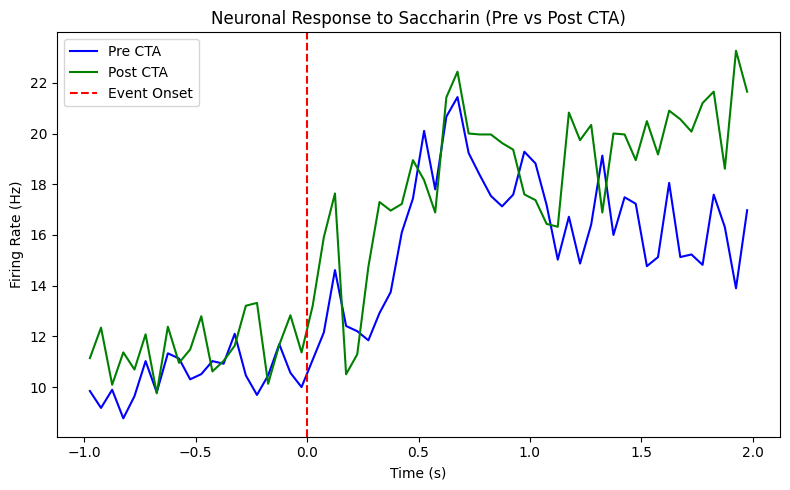

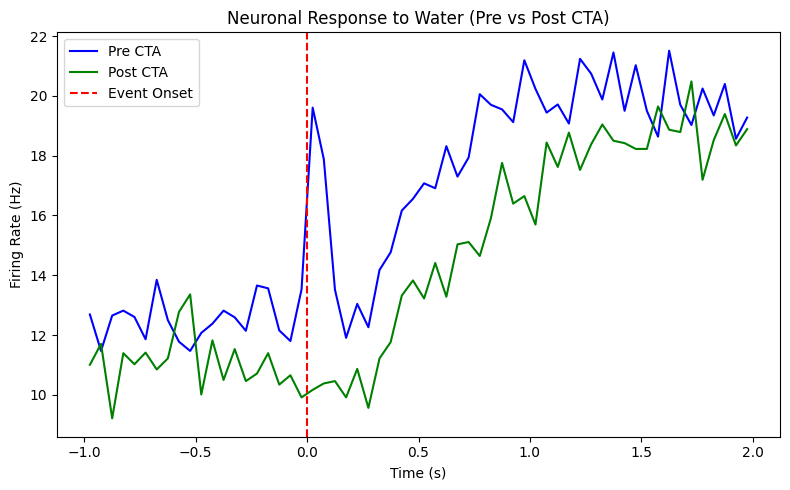

In [49]:
water_times = data["event_times"]["water"]
sugar_times = data["event_times"]["sugar"]  

# For example:
cta_time = data["CTA injection time"]

# Compute PSTH for saccharin (sugar) stimuli
sugar_psth = get_psth(neurons_data, sugar_times, cta_time=cta_time, window=(-1, 2), bin_width=0.05)
# Compute PSTH for water stimuli (using filtered_neurons if necessary)
water_psth = get_psth(neurons_data, water_times, cta_time=cta_time, window=(-1, 2), bin_width=0.05)

# Now, plot each with pre and post CTA conditions
plot_psth(sugar_psth, "Neuronal Response to Saccharin (Pre vs Post CTA)")
plot_psth(water_psth, "Neuronal Response to Water (Pre vs Post CTA)")



In [41]:
import numpy as np
import matplotlib.pyplot as plt

def get_single_neuron_psth(neuron, event_times, cta_time, window=(-1, 2), bin_width=0.05):
    """
    Compute the PSTH for a single neuron for events occurring before and after CTA.
    
    Parameters:
        neuron (tuple/list): A single neuron's data, with spike times at index 2.
        event_times (array-like): Times of the events (e.g., stimulus onsets).
        cta_time (float): The time of the CTA injection.
        window (tuple): Time window (start, end) relative to each event (in seconds).
        bin_width (float): Bin width for the histogram (in seconds).
        
    Returns:
        dict: A dictionary with keys 'pre' and 'post', each containing a tuple:
              (bin_centers, psth) for that condition.
    """
    # Define bins for the histogram
    bins = np.arange(window[0], window[1] + bin_width, bin_width)
    
    # Split event times into pre- and post-CTA based on the provided cta_time
    event_times = np.array(event_times)
    pre_events = event_times[event_times < cta_time]
    post_events = event_times[event_times >= cta_time]
    
    # Extract spike times for this neuron
    spikes = np.array(neuron[2])
    
    # Function to compute PSTH for a given set of events for this neuron
    def compute_for_events(events):
        all_relative_spikes = []
        for event in events:
            # Align spikes to the event time
            rel_spikes = spikes - event
            # Select spikes within the window
            valid_spikes = rel_spikes[(rel_spikes >= window[0]) & (rel_spikes <= window[1])]
            all_relative_spikes.extend(valid_spikes)
        counts, edges = np.histogram(all_relative_spikes, bins=bins)
        # Avoid division by zero if there are no events
        num_events = len(events) if len(events) > 0 else 1
        # Convert counts to firing rate (Hz)
        psth = counts / (num_events * bin_width)
        bin_centers = (edges[:-1] + edges[1:]) / 2
        return bin_centers, psth

    return {
        'pre': compute_for_events(pre_events),
        'post': compute_for_events(post_events)
    }

def plot_neuron_psths(neurons, event_times, cta_time, window=(-1, 2), bin_width=0.05):
    """
    Plot PSTHs for each neuron in a grid with two columns: pre-CTA (left) and post-CTA (right).
    Each row corresponds to one neuron.
    
    Parameters:
        neurons (list): List of neurons, each with spike times at index 2.
        event_times (array-like): Times of the events.
        cta_time (float): Time of CTA injection.
        window (tuple): Time window (start, end) relative to each event.
        bin_width (float): Bin width for the PSTH.
    """
    n = len(neurons)
    # Create a subplot grid with n rows and 2 columns
    fig, axs = plt.subplots(n, 2, figsize=(10, 3 * n), sharex=True, sharey=True)
    
    # If there's only one neuron, ensure axs is 2D
    if n == 1:
        axs = np.array([axs])
    
    for i, neuron in enumerate(neurons):
        # Compute the PSTH for this neuron
        psth_data = get_single_neuron_psth(neuron, event_times, cta_time, window, bin_width)
        
        # Pre-CTA PSTH (left column)
        ax_pre = axs[i, 0]
        bin_centers_pre, psth_pre = psth_data['pre']
        ax_pre.bar(bin_centers_pre, psth_pre, width=bin_centers_pre[1]-bin_centers_pre[0],
                   color="blue", alpha=0.7, edgecolor="black")
        ax_pre.axvline(0, color="red", linestyle="--")
        ax_pre.set_title(f"Neuron {i+1} Pre CTA")
        ax_pre.set_ylabel("Firing Rate (Hz)")
        ax_pre.set_xlabel("Time (s) relative to event")
        
        # Post-CTA PSTH (right column)
        ax_post = axs[i, 1]
        bin_centers_post, psth_post = psth_data['post']
        ax_post.bar(bin_centers_post, psth_post, width=bin_centers_post[1]-bin_centers_post[0],
                    color="green", alpha=0.7, edgecolor="black")
        ax_post.axvline(0, color="red", linestyle="--")
        ax_post.set_title(f"Neuron {i+1} Post CTA")
        ax_post.set_xlabel("Time (s) relative to event")
    
    plt.tight_layout()
    plt.show()


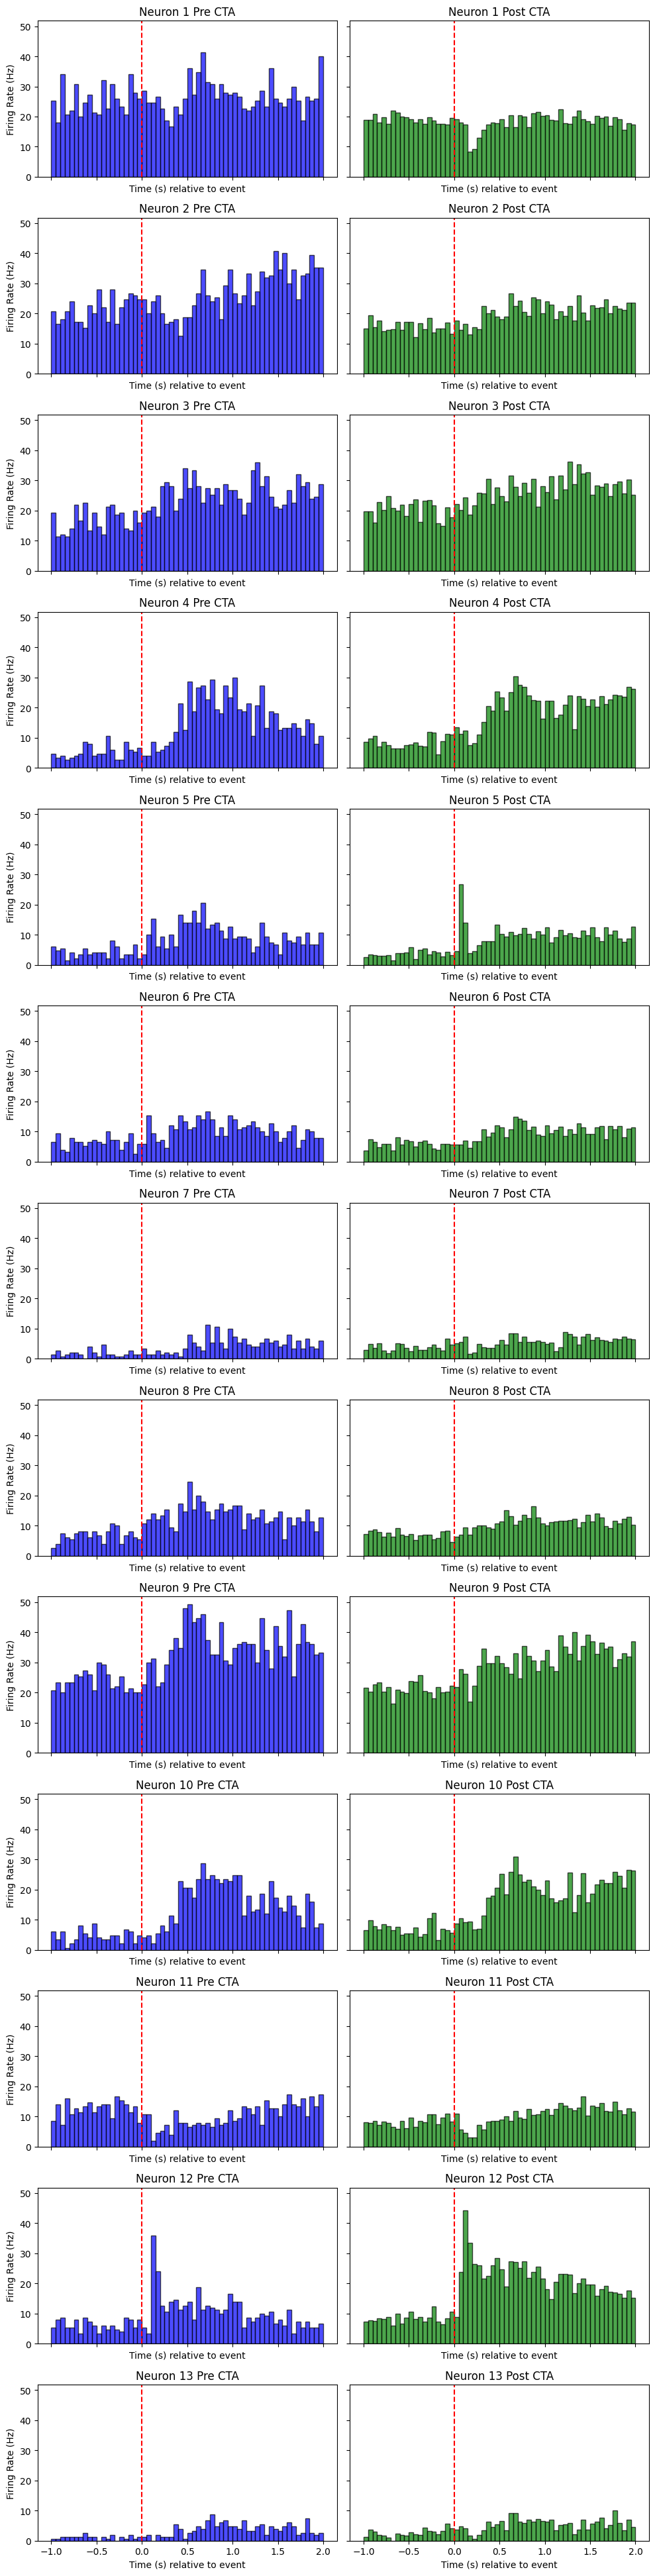

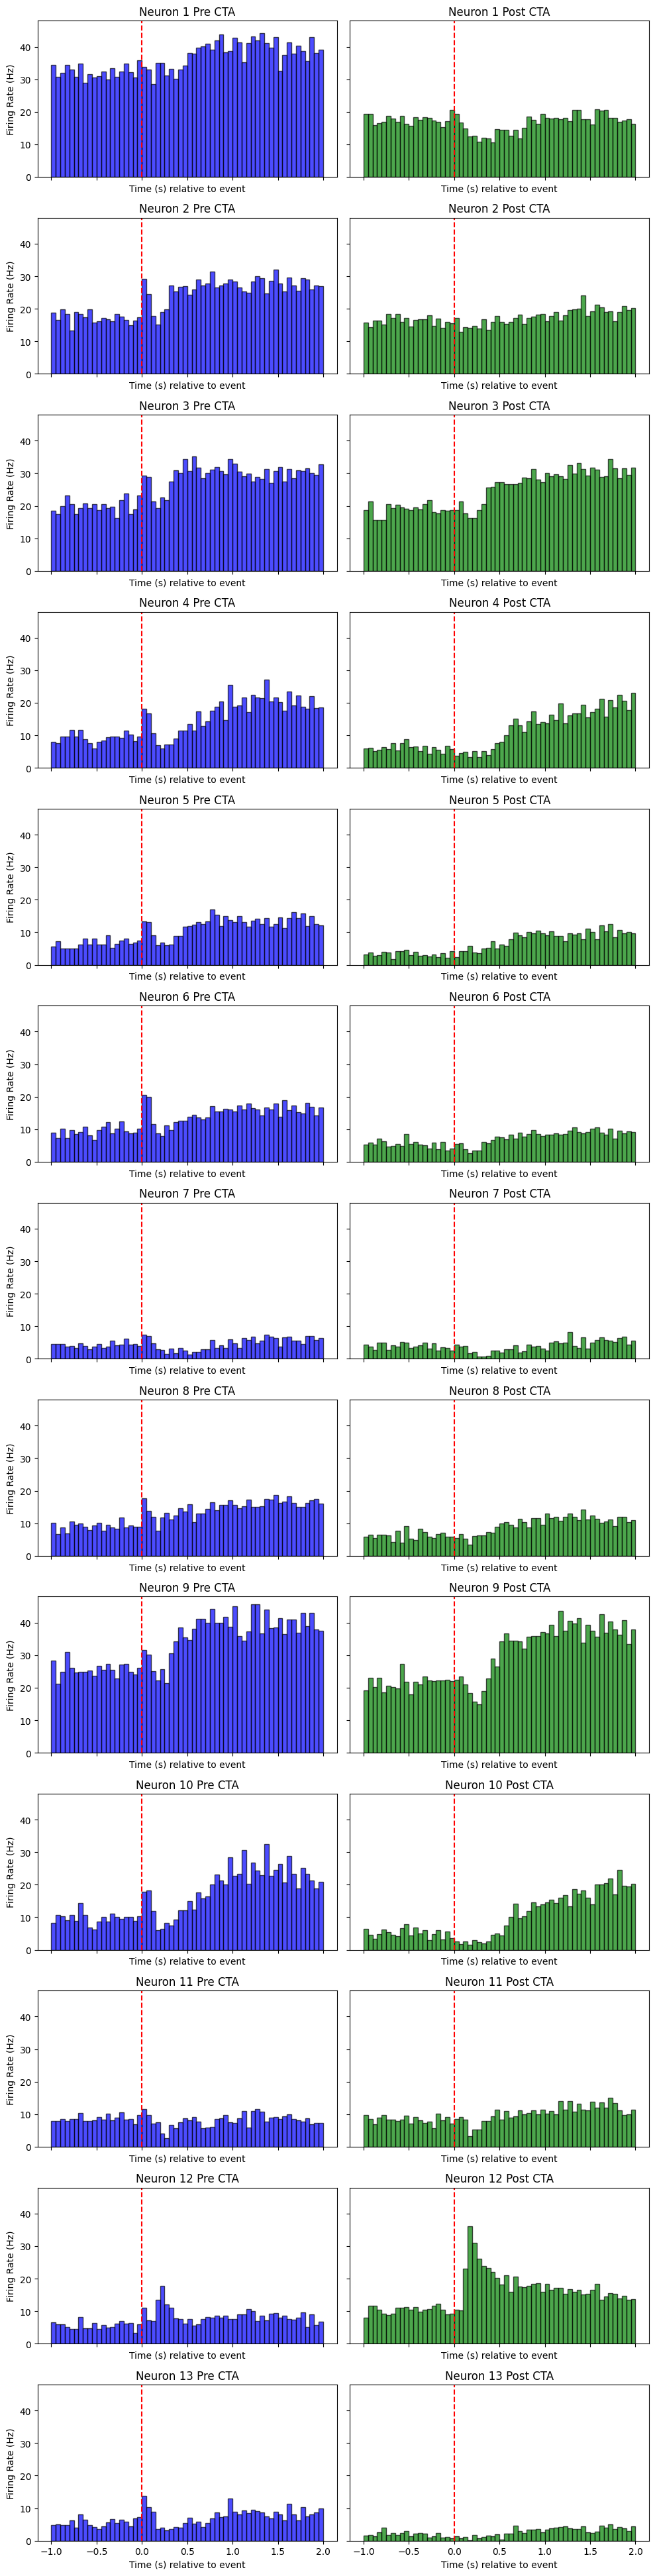

In [44]:
# Suppose:
# - neurons_data is your list of neurons
# - event_times contains your stimulus onsets (e.g., water or sugar events)
# - cta_time is your CTA injection time
plot_neuron_psths(neurons_data, sugar_times, cta_time, window=(-1, 2), bin_width=0.05)
plot_neuron_psths(neurons_data, water_times, cta_time, window=(-1, 2), bin_width=0.05)



Next we can compare the correlogram from pre to post, to check if the connectivity or the spiking patterns have changed

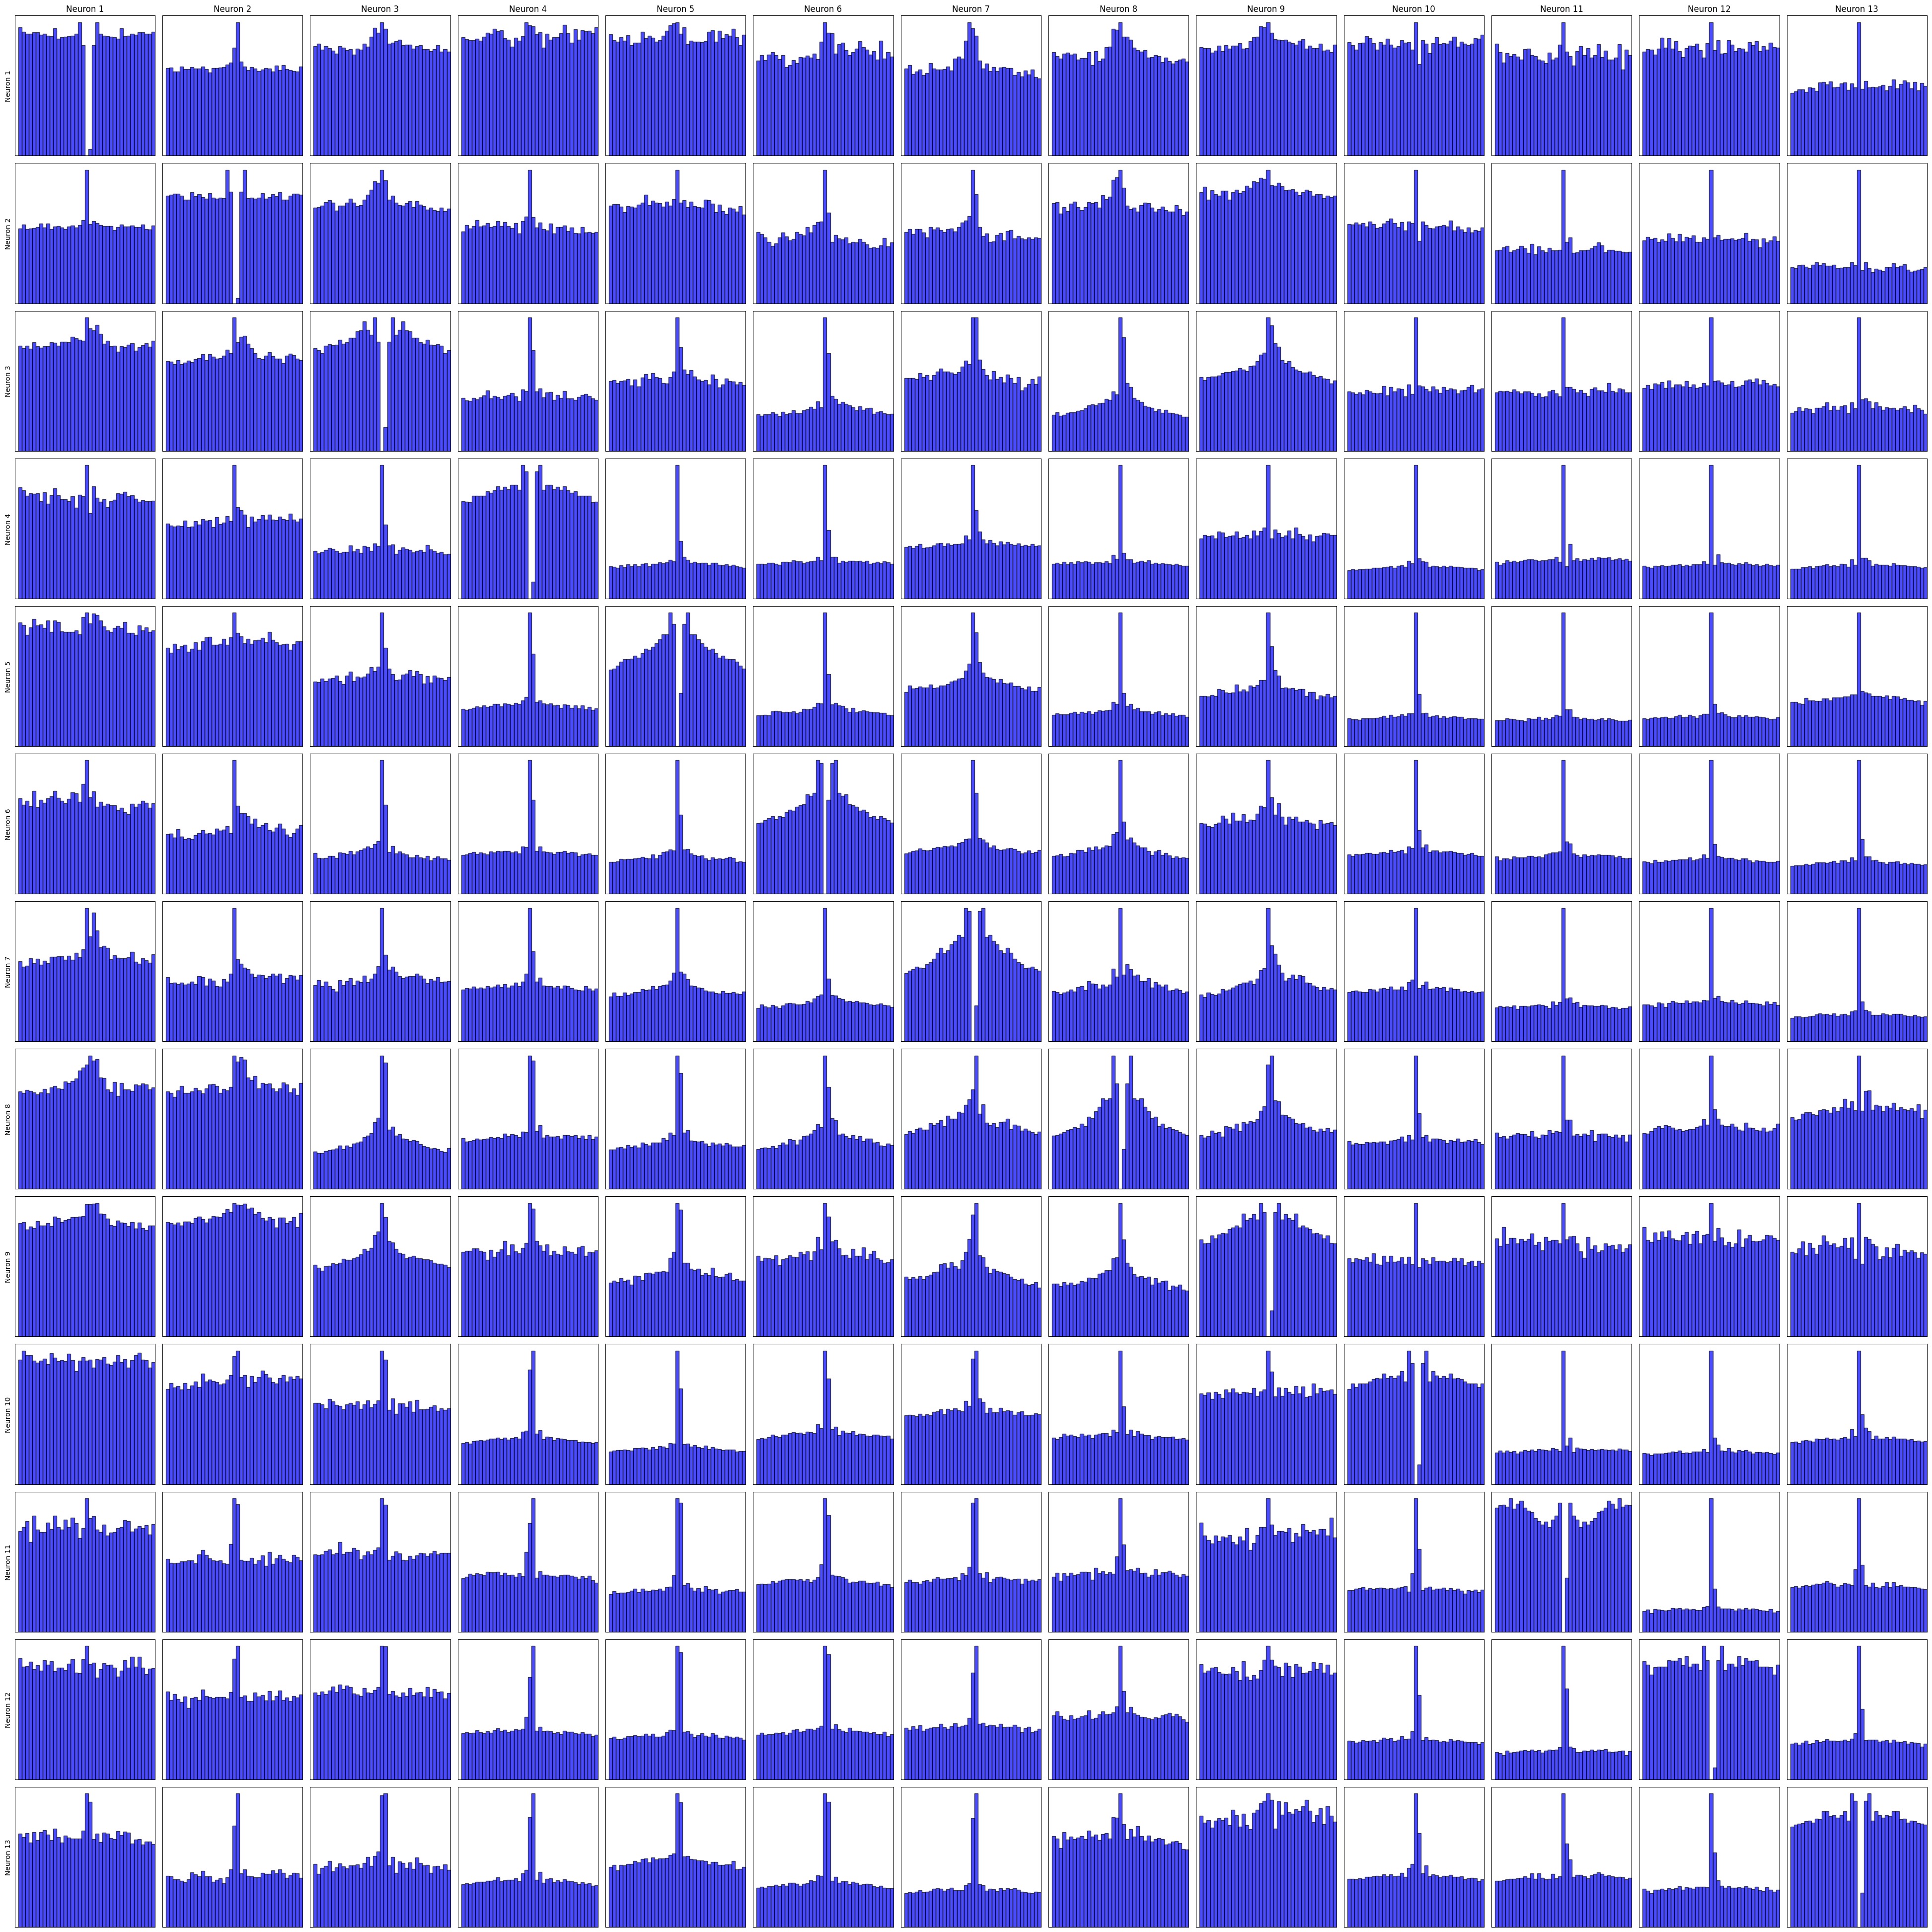

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def plot_correlogram_matrix(neurons_data, binsize=0.001, limit=0.02):
    num_neurons = len(neurons_data)
    fig, axes = plt.subplots(num_neurons, num_neurons, figsize=(num_neurons * 3, num_neurons * 3))
    
    for i, neuron_i in enumerate(neurons_data):
        t1 = neuron_i[:3][2]  # Extract spike times

        for j, neuron_j in enumerate(neurons_data):
            t2 = neuron_j[:3][2]  # Extract spike times

            # Compute correlogram
            counts, bins = correlogram(t1[:cta_time], t2=t2[:cta_time], binsize=binsize, limit=limit, auto=(i == j), density=False)

            # Ensure counts and bins align correctly
            if len(counts) > len(bins) - 1:
                counts = counts[:-1]

            bin_centers = (bins[:-1] + bins[1:]) / 2

            # Plot in the matrix
            ax = axes[i, j] if num_neurons > 1 else axes
            ax.bar(bin_centers, counts, width=np.diff(bins), align='center', color='b', alpha=0.7, edgecolor='k')
            ax.set_xlim(-limit, limit)
            ax.set_xticks([])
            ax.set_yticks([])

            # Labels for the first row and first column
            if i == 0:
                ax.set_title(f"Neuron {j+1}")
            if j == 0:
                ax.set_ylabel(f"Neuron {i+1}")

    plt.tight_layout()
    plt.show()

# Example usage:
plot_correlogram_matrix(neurons_data)


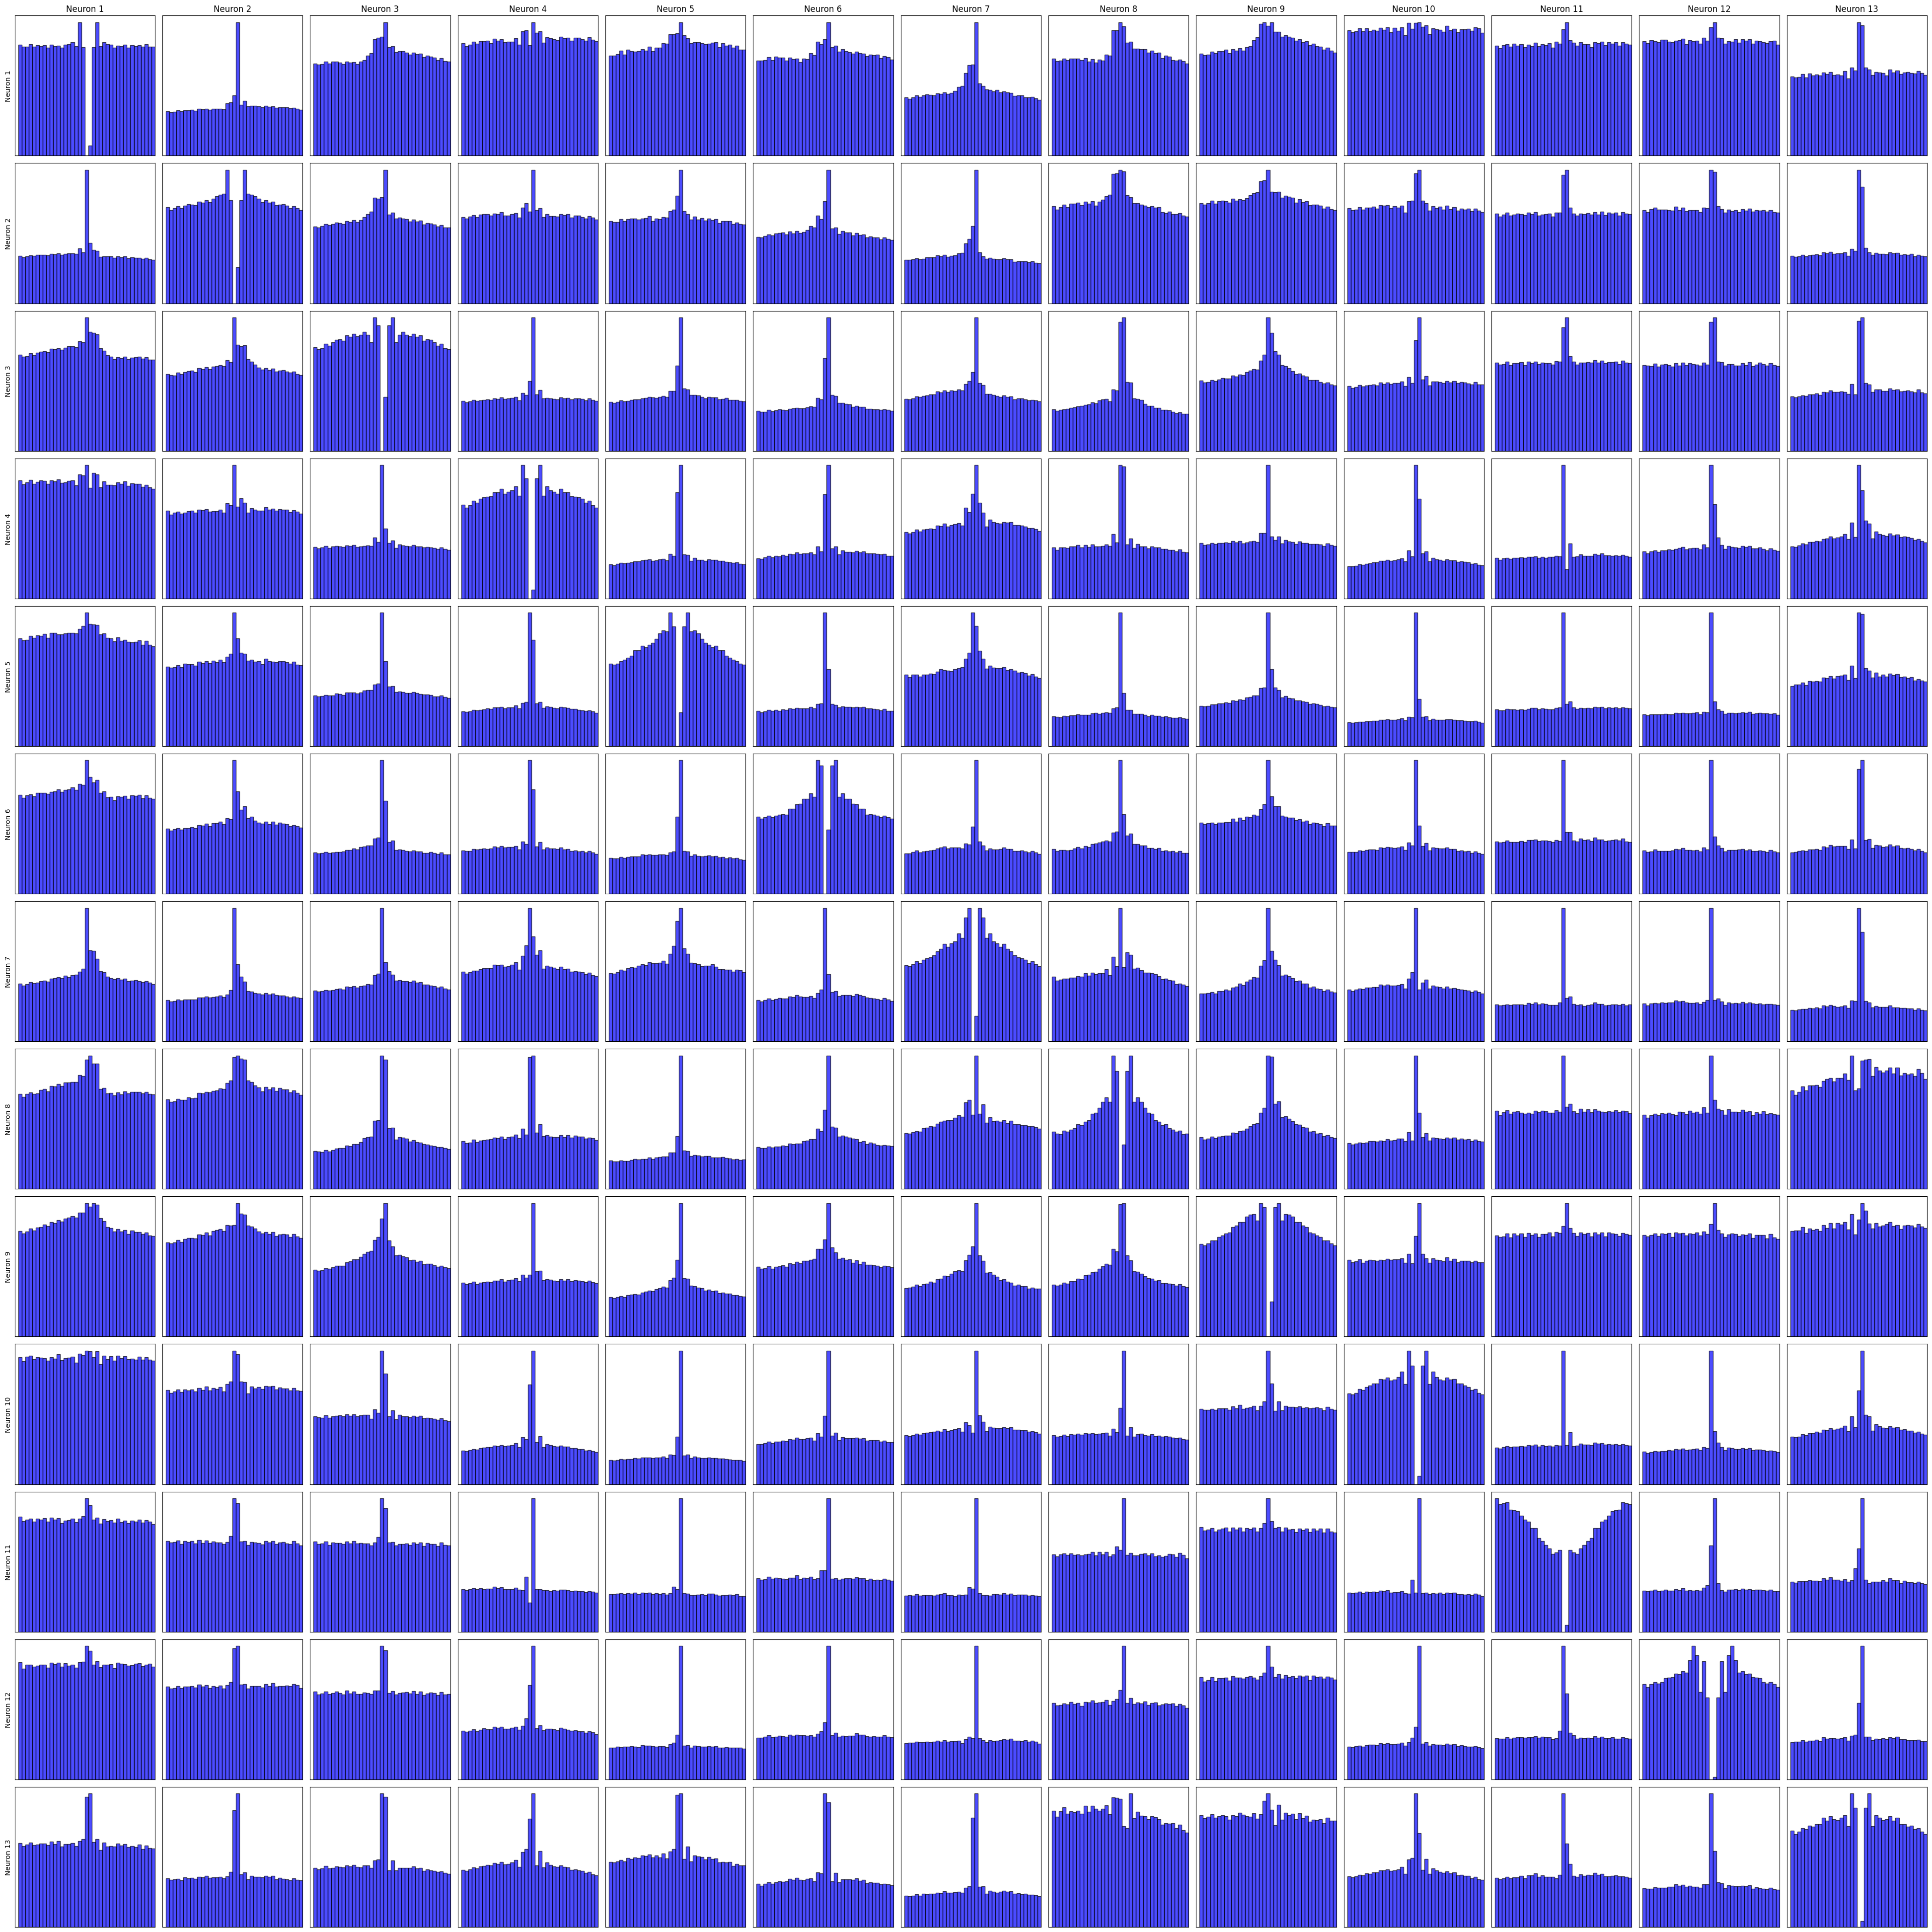

In [53]:
import numpy as np
import matplotlib.pyplot as plt

def plot_correlogram_matrix(neurons_data, binsize=0.001, limit=0.02):
    num_neurons = len(neurons_data)
    fig, axes = plt.subplots(num_neurons, num_neurons, figsize=(num_neurons * 3, num_neurons * 3))
    
    for i, neuron_i in enumerate(neurons_data):
        t1 = neuron_i[:3][2]  # Extract spike times

        for j, neuron_j in enumerate(neurons_data):
            t2 = neuron_j[:3][2]  # Extract spike times

            # Compute correlogram
            counts, bins = correlogram(t1[cta_time + 3 * 3600:], t2=t2[cta_time + 3 * 3600:], binsize=binsize, limit=limit, auto=(i == j), density=False)

            # Ensure counts and bins align correctly
            if len(counts) > len(bins) - 1:
                counts = counts[:-1]

            bin_centers = (bins[:-1] + bins[1:]) / 2

            # Plot in the matrix
            ax = axes[i, j] if num_neurons > 1 else axes
            ax.bar(bin_centers, counts, width=np.diff(bins), align='center', color='b', alpha=0.7, edgecolor='k')
            ax.set_xlim(-limit, limit)
            ax.set_xticks([])
            ax.set_yticks([])

            # Labels for the first row and first column
            if i == 0:
                ax.set_title(f"Neuron {j+1}")
            if j == 0:
                ax.set_ylabel(f"Neuron {i+1}")

    plt.tight_layout()
    plt.show()

# Example usage:
plot_correlogram_matrix(neurons_data)
